In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
)
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import uniform, randint

In [2]:
SEED = 123

### LOAD TRAINSET

In [3]:
DATA_TRAIN_PATH = "../data/trainset.csv"
data_train = pd.read_csv(DATA_TRAIN_PATH, delimiter=",")

In [4]:
cat_variables = ["country","gender","credit_card","active_member"]
dis_variables = ["products_number","tenure","age","credit_score"]
con_variables = ["balance","estimated_salary"]
num_variables = dis_variables + con_variables

target_variable = ["churn"]

### SELECT TARGET AND FEATURES

In [5]:
X_train = data_train.drop(columns=target_variable)
y_train = data_train[target_variable]

### Variable preprocessing
- > numeric variables must be scaled or normalized
- > categorical variables must be encoded

In [6]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore")
classifier = SVC()

TO AVOID DATA-LEAKAGE:
- > we have to use **pipelines** - https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- > Pipeline allows you to apply a list of transformers to preprocess the data sequentially and conclude the sequence with a final predictor.

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler, num_variables),
        ("cat", encoder, cat_variables),
    ]
)

pipe = Pipeline(
            steps=[
                ("preprocessor", preprocessor),
                ("classifier", classifier),
            ]
        )

In [8]:
pipe.fit(X_train, y_train.values.flatten())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['products_number', 'tenure',
                                                   'age', 'credit_score',
                                                   'balance',
                                                   'estimated_salary']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'gender',
                                                   'credit_card',
                                                   'active_member'])])),
                ('classifier', SVC())])

### Cross Validation

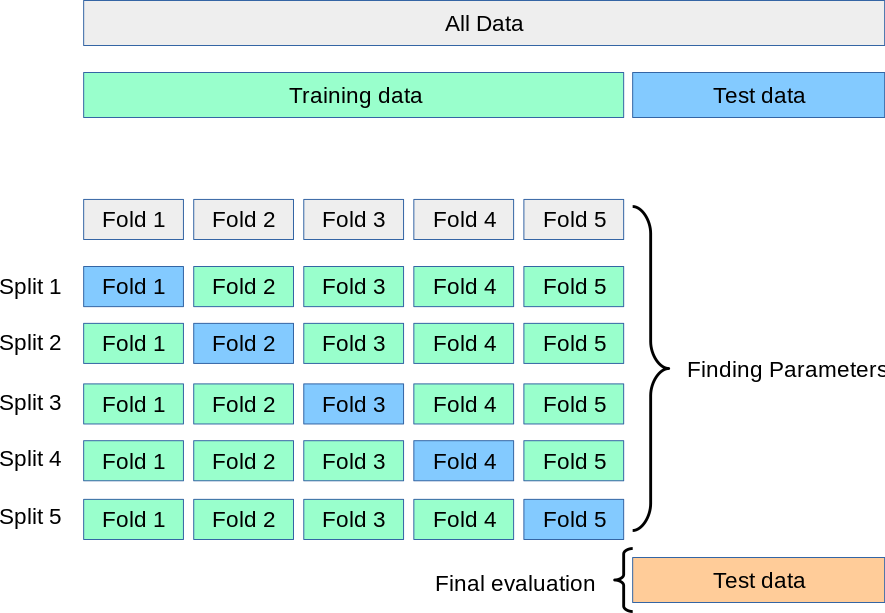

In [9]:
# Initialize StratifiedKFold cross-validator
cross_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Define hyperparameter search space
param_dist = {
    'classifier__C': uniform(0.1, 5),  # Regularization parameter
    'classifier__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'classifier__gamma': uniform(0.1, 1.0),  # Kernel coefficient
    'classifier__degree': randint(1, 5),  # Degree of the polynomial kernel function (if the kernel is 'poly')
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter settings that are sampled
    scoring='accuracy',
    cv=cross_validator,
    refit = True,
    random_state=SEED,
    return_train_score = True
)

# Perform random search
random_search.fit(X_train, y_train.values.flatten())

# Print best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("\nBest Train Score:", random_search.cv_results_["mean_train_score"][random_search.best_index_])
print("\nBest Valid Score:", random_search.best_score_)

Best Parameters: {'classifier__C': 3.582345927989308, 'classifier__degree': 3, 'classifier__gamma': 0.5284709261868257, 'classifier__kernel': 'poly'}

Best Train Score: 0.87734375

Best Valid Score: 0.861125


LOAD TESTSET and SPLIT FEATURES AND TARGET

In [10]:
DATA_TEST_PATH = "../data/testset.csv"
data_test = pd.read_csv(DATA_TEST_PATH, delimiter=",")
X_test = data_test.drop(columns=target_variable)
y_test = data_test[target_variable]

### USE THE BEST PREDICTOR FOR THE TEST SET

In [11]:
y_test_pred = random_search.best_estimator_.predict(X_test)

In [12]:
#accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
#print("Accuracy train:", accuracy_train)
print("Test Score:", accuracy_test)

Test Score: 0.862


### FEATURES IMPORTANCE
- > https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
- > https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

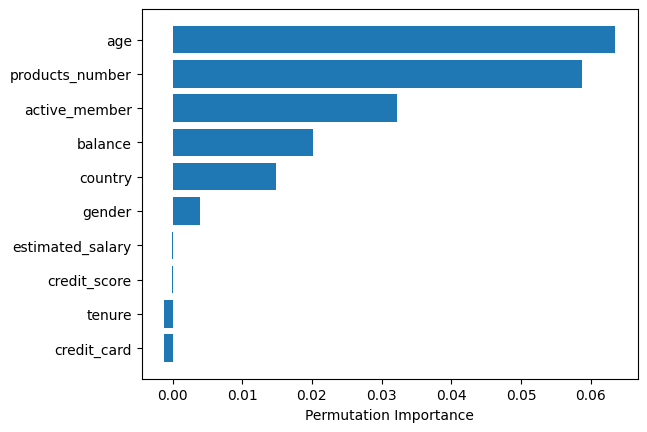

In [21]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt

perm_importance = permutation_importance(random_search.best_estimator_, X_test, y_test, random_state=SEED)
features = np.array(X_test.columns)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");